In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, lfilter, filtfilt, find_peaks,spectrogram
from scipy import interpolate
import pywt
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')

!pip install tslearn

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 8.1 MB/s eta 0:00:00


In [21]:
# load_data
sampling_rate = 100  # Hz
duration = 10

data = np.load('/content/drive/MyDrive/Data/simu_0.1_90_180R.npy')
data_clean = np.load('/content/drive/MyDrive/Data/simu_0_90_180R.npy')
data_clean_NoRR = np.load('/content/drive/MyDrive/Data/simu_0_90_180_NoRR.npy')


signals_labels, signals =  data[:, -6:], data[:, :1000]
signals_clean =  data_clean[:, :1000]
signals_clean_NoRR =  data_clean_NoRR[:, :1000]

In [70]:

def standize(data):
    return (data - np.mean(data))/np.std(data)

# hr [50, 150]
# rr [10, 30]
# hr / 60 * 12 [10, 30]
# rr / 60 * 12 [2, 6]

# N = 120 # ms
# N = 60
# N = 30
# N = 180
# N = 240
time = np.linspace(0, N // 10, N) / 10

# time
signals_ = signals[:, :N]
signals_clean_ = signals_clean[:, :N]
signals_clean_NoRR_ = signals_clean_NoRR[:, :N]

signals_.shape, signals_clean_.shape, signals_clean_NoRR_.shape

((3000, 180), (3000, 180), (3000, 180))

In [71]:
from sklearn.cluster import KMeans

def K_means(signals, num_clusters ):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(signals)
    return cluster_labels


0.209 --> 0.182 --> 0.175 --> 0.173 --> 0.173 --> 0.173 --> 0.173 --> 


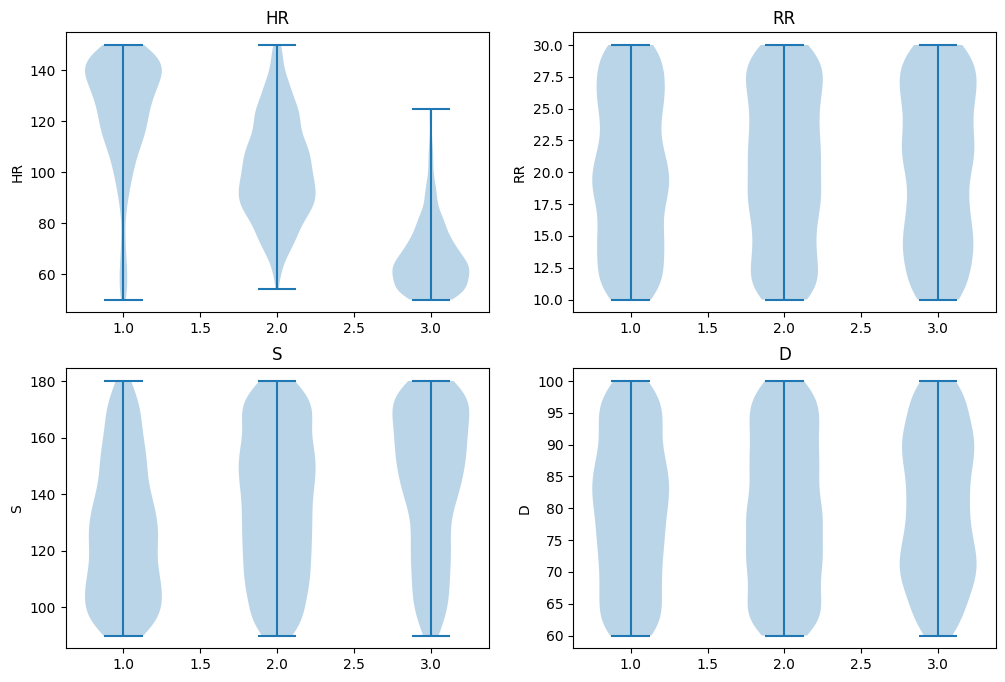

In [72]:
def K_shapes(signal_pieces, num_clusters, show=False, seed=43):
  np.random.seed(seed)

  X_train = signal_pieces
  X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
  sz = X_train.shape[1]

  # kShape clustering
  ks = KShape(n_clusters=num_clusters, verbose=True, random_state=seed)
  y_pred = ks.fit_predict(X_train)

  if show:
    plt.figure()
    for yi in range(num_clusters):
        plt.subplot(num_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        # plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))
    plt.tight_layout()
    plt.show()

  return y_pred


num_clusters = 3

K_shape_labels = K_shapes(signals_, num_clusters)
Methods_labels = K_shape_labels

# K_Means_labels = K_means(signals_clean_, num_clusters)
# Methods_labels = K_Means_labels

all_clustered_HR = []
all_clustered_RR = []
all_clustered_S = []
all_clustered_D = []


for i in range(num_clusters):
  # print(i)
  # clustered_data = signals_clean_[Methods_labels == i]
  clustered_labels = signals_labels[Methods_labels == i]
  all_clustered_HR.append(clustered_labels[:, 2])
  all_clustered_RR.append(clustered_labels[:, 3])
  all_clustered_S.append(clustered_labels[:, 4])
  all_clustered_D.append(clustered_labels[:, 5])
  # print(clustered_data.shape, clustered_labels.shape)


fig, axes = plt.subplots( 2, 2, figsize=(12, 8) )

axes[0, 0].set_title('HR')
axes[0, 0].set_ylabel('HR')
axes[0, 0].violinplot(all_clustered_HR)

axes[0, 1].set_title('RR')
axes[0, 1].set_ylabel('RR')
axes[0, 1].violinplot(all_clustered_RR)

axes[1, 0].set_title('S')
axes[1, 0].set_ylabel('S')
axes[1, 0].violinplot(all_clustered_S)

axes[1, 1].set_title('D')
axes[1, 1].set_ylabel('D')
axes[1, 1].violinplot(all_clustered_D)

plt.show()

In [ ]:
# 仅仅对HR有较为明显的分类作用，对其余三个指标没有啥用处
# 对噪声非常的稳定
# K-shape >> K-means

# 长度的影响呢？对长度也不是很敏感, 总体上是这么一个情况